# Introduction

The purposes of this analysis is to utilize the baseball dataset from http://www.seanlahman.com/baseball-archive/statistics/ and apply the core aspects of the data analysis process using pandas. The data analysis process focuses on the following
1. Asking the Question or what is the Question that needs to be answered. 
2. Performing the Data Wrangling Process, to clean up and massage the data to perform further analysis. 
3. Exploring the data, to collect valuable insight. 
4. Drawing Meaningful Conclusions from the results of Exploration.  
5. Communicating the Results of the Analysis 

Coming from a background in cricket, the analysis uses some of the assumptions made in cricket and applies it to the baseball paradigms (especially with respect to batting) and sees if the hypothesis or the assumptions hold true, with that in mind the analysis focusses on the following 

* Analyzing the "Strikeouts" and the "HomeRuns" aspects of the batters and if there is any relationship among the two batting statistics. The other questions that this analysis helps answer is whether a high strikeout for a batter is a bad thing or does it mean that the high strikeout could also mean that higher a chance of a batter clearing the field for a home run? The analysis also goes the extra step and applies a linear regression model between the dependent and the independent variable and confirms or provides support to the results of the co-relation analysis
* Analyzing the "Batting Average" and the "Runs Scored" aspects of the batter. This analysis paints a different picture compared to the earlier analysis around "Strikeouts" and HomeRuns". 
* On further analysis around some of the other offensive statistics to look for in batters it came across the OPS is a good metric. OPS looks at not only the ability of the batter to get to base, but also the ability of the batter to HIT. On some more thought, if OPS covers the two important aspects of batting, it made sense to ask the question as to how this co-related with the runs scored by the batter during the season. Hence this analysis was focussed on looking at the "OPS" and the "Runs Scored" and the related co-relation.

*Note:* The data has been available since 1871, however given the fact that the game has evolved so much with better equipment and rules changes, it made sense to perform the analysis in the dataset post 2000

# Coding Action
# Importing the needed libraries and Packages

In [482]:
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn import metrics
%matplotlib inline 

# Reading the needed files for the Analysis

In [483]:
raw_batting_df = pd.read_csv('Batting.csv')
raw_battingpost_df = pd.read_csv('BattingPost.csv')
raw_teams_df = pd.read_csv('Teams.csv')

# Data Wrangling - Checking for Count of Missing AT BAT values in the Data Set
We are going to be doing a lot of analysis based on the one of the batting statistics namely "AT BAT", hence in the cell below I try to see how many records in the data set has a null "AT BAT" value. 

In [484]:
raw_batting_df.AB.isnull().sum()

5149

# Creating two functions for re-use later in the Analysis

Function to Calculate the "Batting Average"

In [485]:
def batting_average(hits, atbats):
    avg = hits/atbats
    return avg


Function to Calculate Correlation between two generic values

In [486]:
def correlation(x, y):
    std_x = (x - x.mean())/x.std(ddof=0)
    std_y = (y - y.mean())/y.std(ddof=0)
    correl = (std_x*std_y).mean()
    return correl

# Data Wrangling Step for the Regular Season Batting Data
For the purposes of this analysis we are going to start of by looking at the batting statistics in the regular season. One of the first steps is to read the original dataframe and extract out the records we think are most relevant for the analysis. For the purposes of the analysis we are going to be considering records post year 2000 and also records that have a positive value for "At Bats. 

Based on some research I did, we could also predict the values of the dependent variables from the independent variables using "test train split" approach that comes with the scikit package (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). This process is called imputation https://en.wikipedia.org/wiki/Imputation_(statistics). However for the purposes of this project we are not going to be doing that. That said, I have tried to give "test train split" approach and calculated the predicted values. I have also calculated the R Square value, which is another measure to explain the proportion of the variance in the dependent variable that is predictable from the independent variable. However these additional statistical tests where done to just cross check the results of my correlation test. 

In [487]:
raw_batting_df_nonzeroab = raw_batting_df[(raw_batting_df.AB>0) & (raw_batting_df.yearID>=2000)].copy()

# Validating the results of extraction

In [488]:
raw_batting_df_nonzeroab.head(5)

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
79248,abbotje01,2000,1,CHA,AL,80,215.0,31.0,59.0,15.0,...,29.0,2.0,1.0,21.0,38.0,1.0,2.0,2.0,1.0,2.0
79249,abbotku01,2000,1,NYN,NL,79,157.0,22.0,34.0,7.0,...,12.0,1.0,1.0,14.0,51.0,2.0,1.0,0.0,1.0,2.0
79250,abbotpa01,2000,1,SEA,AL,35,5.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
79251,abreubo01,2000,1,PHI,NL,154,576.0,103.0,182.0,42.0,...,79.0,28.0,8.0,100.0,116.0,9.0,1.0,0.0,3.0,12.0
79252,aceveju01,2000,1,MIL,NL,62,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


# Analysis 1:  "Strike Outs" v/s "Home Runs" Relationship and What it Means
Coming from a cricketing background, strikeout is referred to as a the batsman getting out. In cricket it is called as getting out. A homerun on the other side is a good thing for a batsman. That said, batters who have a high strikeout rate it might not always be a bad thing. It might just mean that they are very aggressive batters and are willing to take the risk of giving the ball a good hit and send it a long distance and in the process there are occasions when they strikeout, contributing to their high strike rate. On the flipside they could also be racking up some high Homeruns during the season. Hence when coaches look at the Strikeout statistics for certain players in the team it might make sense to see it in correlation with the other positive batting statistics and see if there is any sort of correlation 
	
The purpose of the analysis is to look at the correlation between batsman Strikeouts and Home Runs. For this analysis we are going to be using the Home Runs scored as the dependent variable along Y, and the Strikeouts along the independent variable along X. 

The rationale behind selecting these two variables is to look at two contrasting attributes in batting in terms of the final result and help understand whether the relationship between the two variables. 
  

# Analyzing Home Runs Trends Independently

(array([  1.13890000e+04,   1.83700000e+03,   1.07900000e+03,
          7.17000000e+02,   4.97000000e+02,   3.24000000e+02,
          2.09000000e+02,   9.20000000e+01,   7.20000000e+01,
          3.30000000e+01,   1.20000000e+01,   6.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00]),
 array([  0.        ,   4.86666667,   9.73333333,  14.6       ,
         19.46666667,  24.33333333,  29.2       ,  34.06666667,
         38.93333333,  43.8       ,  48.66666667,  53.53333333,
         58.4       ,  63.26666667,  68.13333333,  73.        ]),
 <a list of 15 Patch objects>)

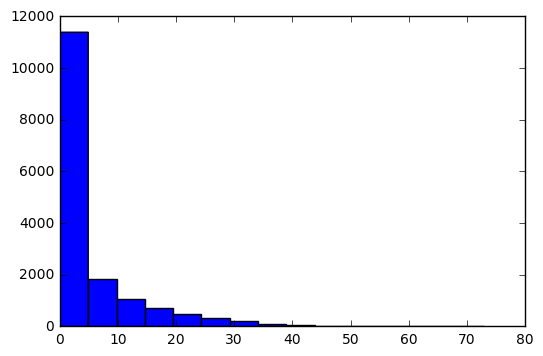

In [489]:
home_runs = raw_batting_df_nonzeroab['HR']
plt.hist(home_runs, bins=15)

# Analyzing Strikeout Trends Independently 

(array([  7.55700000e+03,   2.49500000e+03,   1.51600000e+03,
          1.17200000e+03,   1.01200000e+03,   7.94000000e+02,
          6.56000000e+02,   4.03000000e+02,   3.14000000e+02,
          1.73000000e+02,   8.90000000e+01,   4.60000000e+01,
          2.50000000e+01,   1.30000000e+01,   4.00000000e+00]),
 array([   0.        ,   14.86666667,   29.73333333,   44.6       ,
          59.46666667,   74.33333333,   89.2       ,  104.06666667,
         118.93333333,  133.8       ,  148.66666667,  163.53333333,
         178.4       ,  193.26666667,  208.13333333,  223.        ]),
 <a list of 15 Patch objects>)

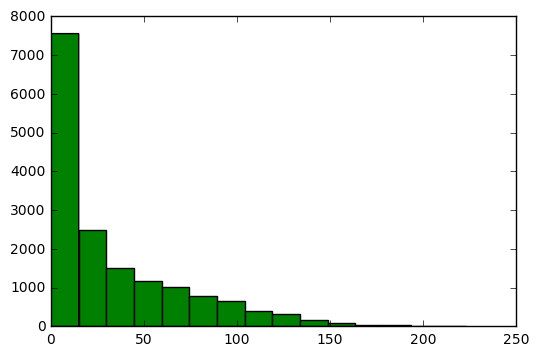

In [490]:
strike_outs = raw_batting_df_nonzeroab['SO']
plt.hist(strike_outs, bins = 15, color = 'g')

# Preliminary Conclusion:
While we started of trying to find some kind of correlation between two datapoints it is very important to look at the data points seperately and chart them to see if there is any kind of similarities that we could potentially find. On plotting out the two datapoints independently as histogram plots we see that the histogram plots have a very similar shape, both the plots are positively skewed. This could potentially mean that there is some level of dependency between the variables, hence we shall do more statiscal analysis to confirm or validate the results of the hypothesis.  



# Advanced Analysis: Calculating the Correlation between Home Runs and Strikeouts by feeding in the strikeouts and homerun data into the earlier function that was created

In [491]:
strike_outs = raw_batting_df_nonzeroab['SO']
home_runs = raw_batting_df_nonzeroab['HR']
print correlation(home_runs,strike_outs)

0.830856261048


The corelation of 0.83 between home runs and strike outs does indicate a high level of co-relation between the two variables in question. A large correlation coefficient does not necessarily indicate that a relationship is casual. Hence before we get too excited about the causual relationship, we need to make sure that the corelation is statistically legitimate. For our sense and purposes, we are going to use additional statistical tests and metrics to determine the relationship between the variables. 



# Visualization: Scatter plot between Strike outs and Home Runs 
One of the first step is to plot a scatter plot between the two variables under analysis

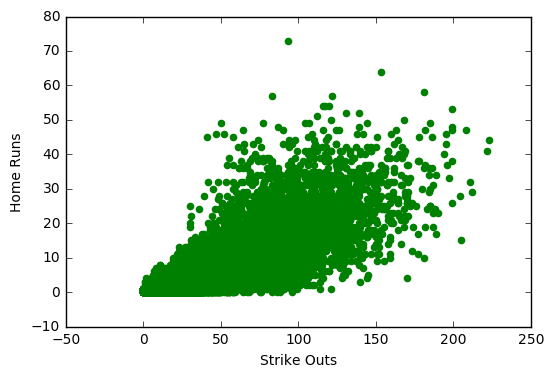

In [492]:
plt.scatter(x=strike_outs,y=home_runs, color='Green')
plt.xlabel('Strike Outs')
plt.ylabel('Home Runs')

# Performing Linear Regression on Strike outs (Independent Variable) and Home Runs (Dependent Variable Y) 
We are going to use some more advanced Linear Regression approach to model the relationship between the Independent Variable and the Dependent Variable under consideration. For the purposes of this analysis we are going to be using the scikit package that comes as a part of python to do the regression analysis on the Independent Variable and the Dependent Variable.

One of the first step while building out the model is to identify the Independent Variable (features) and the Dependent Variable(targets) that needs to be fed into the regression to create a model. 

In [493]:
features_labels = ['SO']
target_labels = ['HR']
features = raw_batting_df_nonzeroab[features_labels]
target = raw_batting_df_nonzeroab[target_labels]

What is "train_test_split" approach? 


While creating a model it is very important to validate the correctness of the model. Hence as a general rule, the data that is used to create the model is not the same data that is used to validate the correctness of the model, else it could lead to other issues like "overfitting". The train_test_split function in scikit essentially allows us to create subsets of data from the population to build a regression model, followed by testing the model on the remaining subset of the data. 

In [494]:

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, test_size = 0.33, random_state = 42)

# Linear Regression
Calling the linear regression model with the selected data groups

In [495]:
lr = LinearRegression()
lr.fit(features_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

# Intercept 
The intercept (often labeled the constant) is the expected mean value of Y when all X=0.

In [496]:
lr.intercept_

array([-1.03990906])

In [497]:
lr.coef_

array([[ 0.17988226]])

# R Squared

R-squared is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression.

R-squared = Explained variation / Total variation

R-squared is always between 0 and 100%:

* 0% indicates that the model explains none of the variability of the response data around its mean.
* 100% indicates that the model explains all the variability of the response data around its mean.

In general, the higher the R-squared, the better the model fits your data

In [498]:
lr.score(features_test, target_test)

0.69902010066465037

The R Square of .699 or 69.9% means that the model explains the variablity around the mean 70% of the time.

# Validating and Assessing the results of the model 

In [499]:
target_pred = lr.predict(features_test)
# UnComment out the line below to see the targer predicted values based on the linear regression model
# zip(target_pred, target_test.HR)

# Final Conclusion -  "Strike Outs" v/s "Home Runs" Relationship and What it Means

The analysis presents that the co-relation between "Strike Outs" and "Home Runs" is a very high 0.83. On first look it  tells a story that a strikeouts and homeruns move together in the positive direction. Hence only looking at the "Strikeouts" stats for a batter while judging his performance might not be a good indicator.It probably needs to be looked into conjunction with other batting stats and evaluated appropriately.

We also tried to validate the results of the correlation using another stastical test and calculated the R square value. The R Square for our test was 69.9%. The value for R Square can be between 0 and 100%. 0% indicates that the model explains none of the variability of the response data around its mean.100% indicates that the model explains all the variability of the response data around its mean. Our number of 69.9 (~70%) indicates that the model explains the variability of the predicted data around 70% of the time. 

# Some Visible Limitations 

The limitations of this analysis can be categorized into three sections 
* Analysis on the Subset of the Data can sometimes skew the results in one direction 
* Looking at only one Dependent Variable (In real life situations, we will be looking at hundreds of dependent variables and analyzing its impact on the Independent Variable) 
* Correlation Does not Mean Causation


**Analysis on the Subset of Data**:

While the results of the initial analysis and some of the advanced analysis using simple linear regression model does help explain some of the answers we are trying to answer around the correlation between "Strike Outs" and "Home Runs" it can not be said that the analysis is perfect or error free. Any kind of data analysis in the real world comes up some level of assumptions and selective data extraction. In our example, we extracted the data post 2000 and also we chose to only pick records where we had a valid value for "Strike Outs" and "Home Runs". While the former was pretty straight forward, the later was done by looking for "AT BATS" values greater than "0". While this data analysis choose to ignore certain records based on certain conditions, we always run the risk of **skewing** our results of the analysis. 

**Analysis on one Dependent Variable**

Further analysis could also be done by looking at more dependent variables and validating the impact on the independent variables. E.g. Instead of looking at just the "Strike Outs" we could also look for other dependent variables like "Stolen Bases" or "Hits". The other approach could be do individual analysis across the different depenendent variables and identify the best dependent variable to be chosen to analyze the behavior of the independent variable. 

**Corelation Does not Mean Causation**

While the analysis does look at the variables independently, followed by looking at the co-relation, followed by doing some additional linear regression tests to calculate the R Square value. A lot of the conclusion is based on the results of the corelation between the two variables. Based on some addition research some of the other tests that data analyst have generally done are Random Forest Test, Anova test, F Test. 

# Analysis 2:  "Batting Average" v/s "Runs Scored" and what it means
For someone like me who is trying to learn baseball from the heels of a very similar game in cricket,  the batting average is a huge statistic in cricket and in most cases a high batting average in a season more or less means high number of runs scored. The analysis looks at whether batting average is a good measure of the runs scored by a batsman. Ideally speaking (and also based on my experience with following stats in Cricket), a high batting average generally means the batsman is an above average batsman, which should almost always translate to the runs scored. 
	
The purpose of the analysis is to review the correlation between the runs scored by batsman (provided as a part of the dataset) and the batting average, that is yet to be computed based on the data provided. For this analysis I am going to be using runs scored as a the dependent variable along Y, and the calculated batting average as the independent variable along X 

# Data Wrangling - Batting Average

Calculating the batting average using the "Home Runs" and "At Bats". 

We are using the vectorized operation (np.vectorize) to calculate the batting average for each record in the dataframe

In [500]:
raw_batting_df_nonzeroab['batting_average'] = np.vectorize(batting_average)(raw_batting_df_nonzeroab['H'], 
                                                                            raw_batting_df_nonzeroab['AB'])

# Analyzing Batting Average Independently 
One of the key elements while analyzing any data element is to validate the behavior of the element independently. It is called as single variable exploration, where in the variable under analysis is looked at the by itself independently, or before any modifications. For the purpose of our analysis we are going to be looking at the trend of the batting average and runs scored using simple histogram plots and/or boxplots. 

In the cell below, we are extracting the batting average from the original dataframe and storing the result in a new  dataframe for easily plotting into the box plot or histogram 

In [501]:
batting_average_df = raw_batting_df_nonzeroab.batting_average.to_frame()

# BoxPlot for Batting Average 

C:\Users\achristudas\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


{'boxes': [<matplotlib.lines.Line2D at 0x2d9baa58>],
 'caps': [<matplotlib.lines.Line2D at 0x2d9ca7b8>,
 'fliers': [<matplotlib.lines.Line2D at 0x2e927860>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x2e9272e8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x2d9bac18>,
  <matplotlib.lines.Line2D at 0x2d9ca240>]}

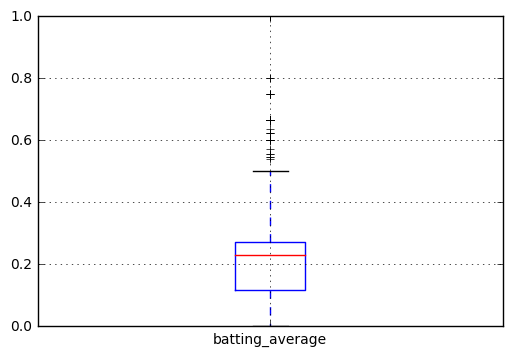

In [502]:
batting_average_df.boxplot()

# Histogram for Batting Average 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000002D9586D8>]], dtype=object)

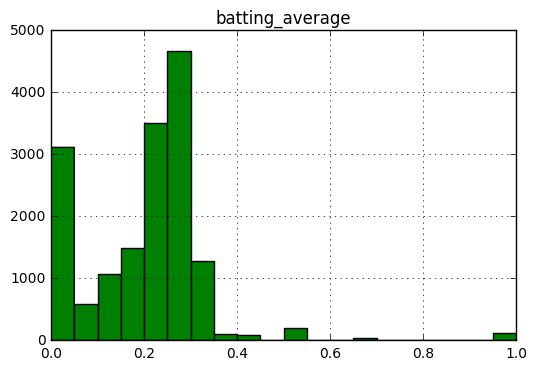

In [503]:
batting_average_df.hist(bins=20, color ='g')

The boxplot and Histogram plots for Batting Average gives us some very interesting pieces of information on the data. We see that there are definitely a huge frequency of batters who have a zero batting average, and then we also see that there are a few batters who have a batting average of greater than .5. As it can be seen from the plots above the mean of the batting average across the league is around 0.23. 

On further analysis of the vizualization plots and looking at the high frequency of the batting averages being "0" we noticed that the count "At Bats" were really low. Hence for the purpose of analyzing the impact of batting averages and runs scored, we had to extract out datapoints where the batting average was greater than "0". This was done so that the results are not skewed and it also forms a better basis for our hypothesis to see the impacts of batting average on the runs scored. 

In [504]:
int_nonzero_batting_average_df = raw_batting_df_nonzeroab[raw_batting_df_nonzeroab.batting_average>0].copy()
nonzero_batting_average = int_nonzero_batting_average_df[int_nonzero_batting_average_df.batting_average<=0.5].copy()


# New Histogram Plot for Batting Averages

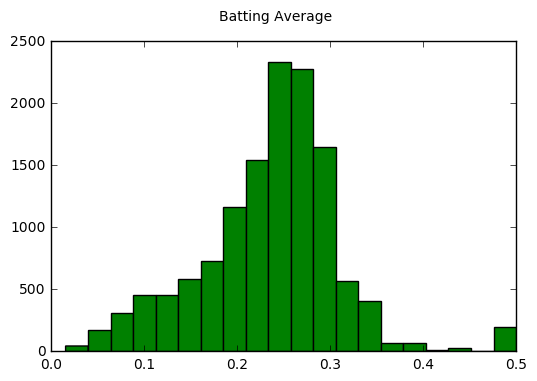

In [505]:
plt.hist([nonzero_batting_average['batting_average']], bins=20, color ='g')
plt.suptitle("Batting Average")

# Analyzing the Runs Scored Independently
# Extracting the Runs Scored
We are extracting the runs scored for the dataset, where the batting average is greater than 0.0 but smaller than 0.5. 

In [506]:
runs_scored_df = raw_batting_df_nonzeroab[(raw_batting_df_nonzeroab.batting_average>0) 
                                          & (raw_batting_df_nonzeroab.batting_average<=0.5)].copy()

Extracting the Runs Scored Column from the original dataframe into a new dataframe for the purposes of analysis

In [507]:
runs_scored = runs_scored_df.R.to_frame()

# BoxPlot for Runs Scored 

C:\Users\achristudas\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


{'boxes': [<matplotlib.lines.Line2D at 0x2a2ebd68>],
 'caps': [<matplotlib.lines.Line2D at 0x2a2fdac8>,
 'fliers': [<matplotlib.lines.Line2D at 0x2a30bb70>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x2a30b5f8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x2a2ebf28>,
  <matplotlib.lines.Line2D at 0x2a2fd550>]}

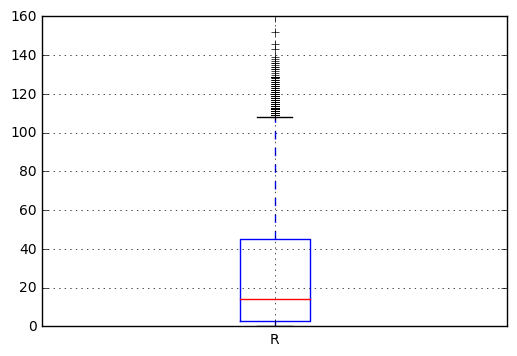

In [508]:
runs_scored.boxplot()

# Histogram Plot for Runs Scored

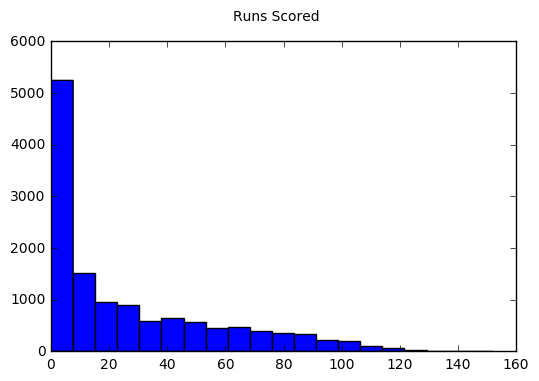

In [509]:
plt.hist([runs_scored_df['R']], bins=20)
plt.suptitle("Runs Scored")

# Preliminary Conclusion:
While we started of trying to find some kind of correlation between two datapoints it is very important to look at the data points seperately and chart them to see if there is any kind of similarities that we could potentially find. On plotting out the two datapoints independently as histogram plots we noticeably see that the histogram plots have two different shapes. This helps us make the assumption that we are probably looking at two datasets that do not have a  relationship. 

A lot of times we could run into this problem in data analysis when we start of by looking at the distinct datapoints with the purpose of trying to chart out a relationship between then only to determine that there might not be a strong relationship as we had earlier assumed. It is at this point we go into the next level of statistical analysis like identifying the correlation, and performing other kinds of statistical tests

# Correlation Between Batting Average and Runs Scored

In [510]:
batting_avg = nonzero_batting_average['batting_average']
runs_scored = runs_scored_df['R']
print correlation(batting_avg,runs_scored)

0.390432559179


# Scatter plot between Batting Average and Runs Scored
The scatter plot here is the simplest way to show a visualization between "Batting Average" and "Runs Scored" 

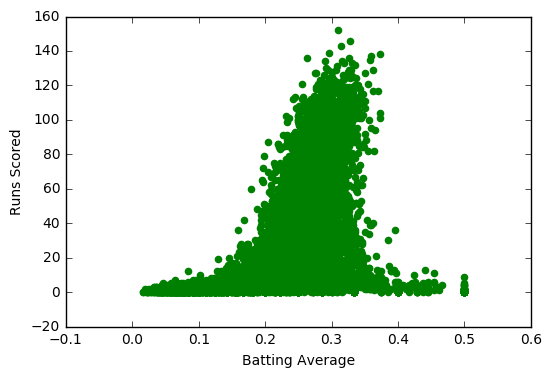

In [511]:
plt.scatter(x=batting_avg,y=runs_scored, color='Green')
plt.xlabel('Batting Average')
plt.ylabel('Runs Scored')

 # Final Conclusion - "Batting Average" and "Runs  Scored" and what it means

The analysis presents a positive 0.38 correlation between "Batting Average" and "Home Runs". As a general rule of thumb and based on referencing the material in https://explorable.com/statistical-correlation, for the purposes of our analysis we can assume that "Batting Average" and "Home Runs" have a very weak relationship. Hence we should look to analyze some other batting statistics to see the batter efficiency. For the purposes of this project I am not doing further linear regression as performed in the other data set

In addition looking at the two variables independently and charting out the histogram plots gave a decent assesment of the lack relationship between the dependent and the independent variables. 

# Analysis 3: Does a high OPS always translate to Higher Runs being Scored by the Team? 

A lot of baseball statisticians are not a big fan of the traditional batting statistics (e.g. Batting Average,RBI) to evaluate the value of a batter). OPS was created to evaluate the ability of the player to get to bases and the powwer of the batter to get the needed hits. It is fair to assume the the players with high OPS would contribute heavily to the teams runs scored. The purpose of this analysis is to review that hypothesis. That said, OPS needs to be calculated based on already available batting statistics


# Data Wrangling - Making a copy of the Teams Data Frame to Include Data Post 2000

In [512]:
teams_df = raw_teams_df[(raw_teams_df.yearID>=2000)].copy()
# teams_df.head()

# Fixing the data type on for "AT BATS", "Hits" & "Base on Balls" as Float (Earlier it was set to Integer)
The float datatype comes in handy while doing analysis and also while dealing with decimal places. Baseball being a game where every decimal counts having the datapoints to be analyzed in a float datatype can come in very handy. 

In [513]:
teams_df.AB = teams_df.AB.astype(float)
teams_df.H = teams_df.H.astype(float)
teams_df.BB = teams_df.BB.astype(float)

In [514]:
teams_df.head(5)

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
2325,2000,AL,ANA,ANA,W,3,162,81.0,82,80,...,182.0,0.978,Anaheim Angels,Edison International Field,2066982.0,102,103,ANA,ANA,ANA
2326,2000,NL,ARI,ARI,W,3,162,81.0,85,77,...,138.0,0.982,Arizona Diamondbacks,Bank One Ballpark,2942251.0,105,103,ARI,ARI,ARI
2327,2000,NL,ATL,ATL,E,1,162,81.0,95,67,...,138.0,0.979,Atlanta Braves,Turner Field,3234304.0,101,99,ATL,ATL,ATL
2328,2000,AL,BAL,BAL,E,4,162,81.0,74,88,...,151.0,0.981,Baltimore Orioles,Oriole Park at Camden Yards,3297031.0,95,96,BAL,BAL,BAL
2329,2000,AL,BOS,BOS,E,2,162,81.0,85,77,...,120.0,0.982,Boston Red Sox,Fenway Park II,2585895.0,104,103,BOS,BOS,BOS


# Prior to calculating the OPS, a few other data points needs to be created. The next couple of  cells calculates the intermediate data points before calculating the value for OPS 

# Calculating 1B

In [515]:
teams_df['1B'] = teams_df['H'] - teams_df['2B'] - teams_df['3B'] - teams_df['HR']

# Calculating Total Bases

Total bases (TBs) is the number of bases a player has gained with hits. It is a weighted sum for which the weight value is 1 for a single, 2 for a double, 3 for a triple and 4 for a home run. Only bases attained from hits count toward this total.

In [516]:
teams_df['TB'] = (teams_df['1B'] + (2*teams_df['2B']) + (3*teams_df['3B']) + (4*teams_df['HR']))

# Calculating Slugging Percentage

Slugging percentage(abbreviated SLG) is a popular measure of the power of a hitter. It is calculated as total bases divided by at bats: where AB is the number of at-bats for a given player, and 1B, 2B, 3B, and HR are the number of singles, doubles, triples, and home runs, respectively.

In [517]:
teams_df['SLG'] = teams_df['TB']/teams_df['AB']

# Calculating Onbase Percentage 

Onbase Percentage is measure of how often a batter reaches base for any reason other than a fielding error, fielder's choice, dropped/uncaught third strike, fielder's obstruction, or catcher's interference

In [518]:
teams_df['OBP'] = ((teams_df['H'] + teams_df['BB'] + teams_df['HBP'])/(teams_df['AB']+ teams_df['BB'] + teams_df['SF'] +
                                                                     teams_df['HBP']))

# Calculating Onbase Plus Slugging (OPS) 

OPS adds on-base percentage and slugging percentage to get one number that unites the two. It's meant to combine how well a hitter can reach base, with how well he can hit for average and for power. As a result, OPS is widely considered one of the best evaluative tools for hitters.

In [519]:
teams_df['OPS'] = teams_df['OBP'] + teams_df['SLG']

In [520]:
runs = teams_df['R']
ops =  teams_df['OPS']

# Analyzing the OPS Score Independently

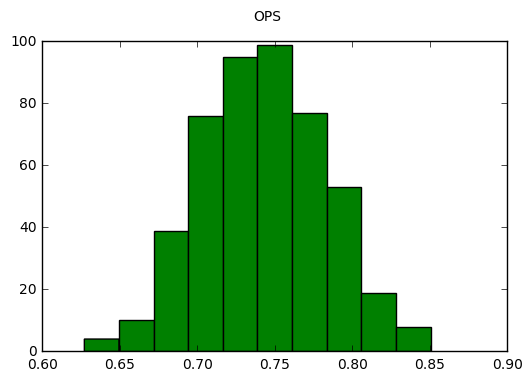

In [521]:
plt.hist(ops, color ='g')
plt.suptitle("OPS")

# Analyzing Runs Scored Independently

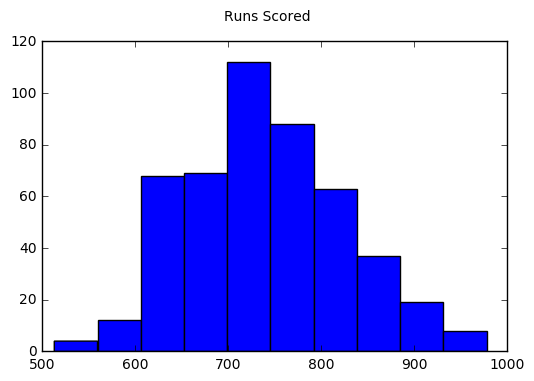

In [522]:
plt.hist(runs)
plt.suptitle("Runs Scored")

# Calculating the Correlation Between Runs and OPS

In [523]:
print correlation (runs, ops)

0.955407042704


There is a high degree of corelation between OPS and the Runs Scored by the team. However, we need to be sure that this is not a case of spurious corelation, also another thing to keep in mind is that correlation does not always means causation, hence it is important to apply other kinds of statistical tests and confirm the hypothesis.

# Performing Linear Regression on OPS (Independent Variable) and Runs Scored (Dependent Variable Y)
We are going to use some more advanced Linear Regression approach to model the relationship between the Independent Variable and the Dependent Variable under consideration. For the purposes of this analysis we are going to be using the scikit package that comes as a part of python to do the regression analysis on the Independent Variable and the Dependent Variable.

One of the first step while building out the model is to identify the Independent Variable (features) and the Dependent Variable(targets) that needs to be fed into the regression to create a model. 

In [524]:
features_labels = ['OPS']
target_labels = ['R']
features = teams_df[features_labels]
target = teams_df[target_labels]

**What is "train_test_split" approach?** 

While creating a model it is very important to validate the correctness of the model. Hence as a general rule, the data that is used to create the model is not the same data that is used to validate the correctness of the model, else it could lead to other issues like "overfitting". The train_test_split function in scikit essentially allows us to create subsets of data from the population to build a regression model, followed by testing the model on the remaining subset of the data. 

In [525]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, test_size = 0.33, random_state = 42)

In [526]:
lr = LinearRegression()
lr.fit(features_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

# R Squared

R-squared is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression.

R-squared = Explained variation / Total variation
R-squared is always between 0 and 100%:

* 0% indicates that the model explains none of the variability of the response data around its mean.
* 100% indicates that the model explains all the variability of the response data around its mean.

In general, the higher the R-squared, the better the model fits your data

In [527]:
lr.score(features_test, target_test)

0.91089540171767824

The R Square value of .91 means that the model explains the variance 91% percent of the time 

# Final Conclusion: Does a high OPS always translate to Higher Runs being Scored by the Team?

There is a high degree of positive corelation between OPS and Runs Scored. Hence we can safely assume that teams whose batters would have a high OPS would result in the respective teams having higher runs scored. We have also applied the linear regression methodology and calculated the R Squared value. The R Square value of 91% lends more credibility to the initial hypothesis that there is a high level of positive correlation between the independent and dependent variables. 

While the results of the correlation and linear regression provide support to the hypothesis, the limitations discussed in the first analysis apply well to this analysis as well. It can well be categorized into the following 

* Analysis on the Subset of the Data can sometimes skew the results in one direction. 
* Analysis one Dependent Variable (In real life situations, we will be looking at hundreds of dependent variables and analyzing its impact on the Independent Variable). 
* Correlation Does not Mean Causation. Additional statistical tests (Random Forest, F Test, Z Test) could be performed to provide more valuable insight. 


## References
* http://sabr.org/sabermetrics
* https://www.uu.edu/dept/math/SeniorPapers/01-02/Patterson.pdf
* http://m.mlb.com/glossary/standard-stats/on-base-plus-slugging
* http://myyouthbaseball.com/understanding-using-baseball-statistics.html
* http://www.fangraphs.com/library/offense/ops/
* http://www.eg.bucknell.edu/~bvollmay/baseball/runs1.html
* https://www.uu.edu/dept/math/SeniorPapers/01-02/Patterson.pdf 
* http://blog.yhat.com/posts/scraping-and-analyzing-baseball-data-with-r.html
* http://digitalcommons.calpoly.edu/cgi/viewcontent.cgi?article=1000&context=statsp
* http://thesportjournal.org/article/an-examination-of-the-moneyball-theory-a-baseball-statistical-analysis/
* http://emeyers.scripts.mit.edu/emeyers/teaching/cs-0149-introduction-to-statistics-through-baseball/ - 
* https://books.google.com/books?id=1mNZfyil2ecC&pg=PA3&lpg=PA3&dq=what+baseball+statistics+to+statisticians+look+for&source=bl&ots=oY5ykZna04&sig=zvkhx9C0vMghwz-xHxguatZFgnk&hl=en&sa=X&ved=0ahUKEwiQr_7cte_QAhVqzVQKHdehAko4ChDoAQgfMAE#v=onepage&q=what%20baseball%20statistics%20to%20statisticians%20look%20for&f=true
* http://www.predictem.com/mlb/stats.php
* http://maps.unomaha.edu/maher/GEOL2300/week3/week3.html
* http://pandas.pydata.org/pandas-docs/version/0.18.1/visualization.html
